In [112]:
from wandb_utils import RunInfo
from datetime import datetime
import pandas as pd

In [113]:
runs = RunInfo.fetch(
    since=datetime(2023, 7, 17, 0)
)

In [114]:
df = pd.DataFrame(
    [
        {
            "run": run,
            "split_type": run.split.type,
            "split_fold": run.split.index,
            "rmsd_threshold": run.get("filter_rmsd_max_value"),
            "test/corr": run.run.summary.get("test/corr", None),
            "test/mae": run.run.summary.get("test/mae", None),
            "model": run.model_name
        }
        for run in runs
    ]
).dropna().drop_duplicates(subset = ["split_type", "split_fold", "rmsd_threshold", "model"])

In [115]:
U = {
    "split_type": ["scaffold-k-fold", "pocket-k-fold", "random-k-fold"],
    "split_index": list(range(5)),
    "rmsd_threshold": [2, 4, 6],
    "model": ["Structural Transformer", "Covalent Transformer"]
}

In [116]:
from itertools import product
matrix = {
    (split, index, rmsd, model): []
    for split, index, rmsd, model in product(*U.values())
}

In [117]:
for i, row in df.iterrows():
    matrix[(
        row["split_type"],
        row["split_fold"],
        row["rmsd_threshold"],
        row["model"]
    )].append(row["test/corr"])

In [118]:
sum(len(runset) > 0 for runset in matrix.values()), len(matrix.values())

(90, 90)

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

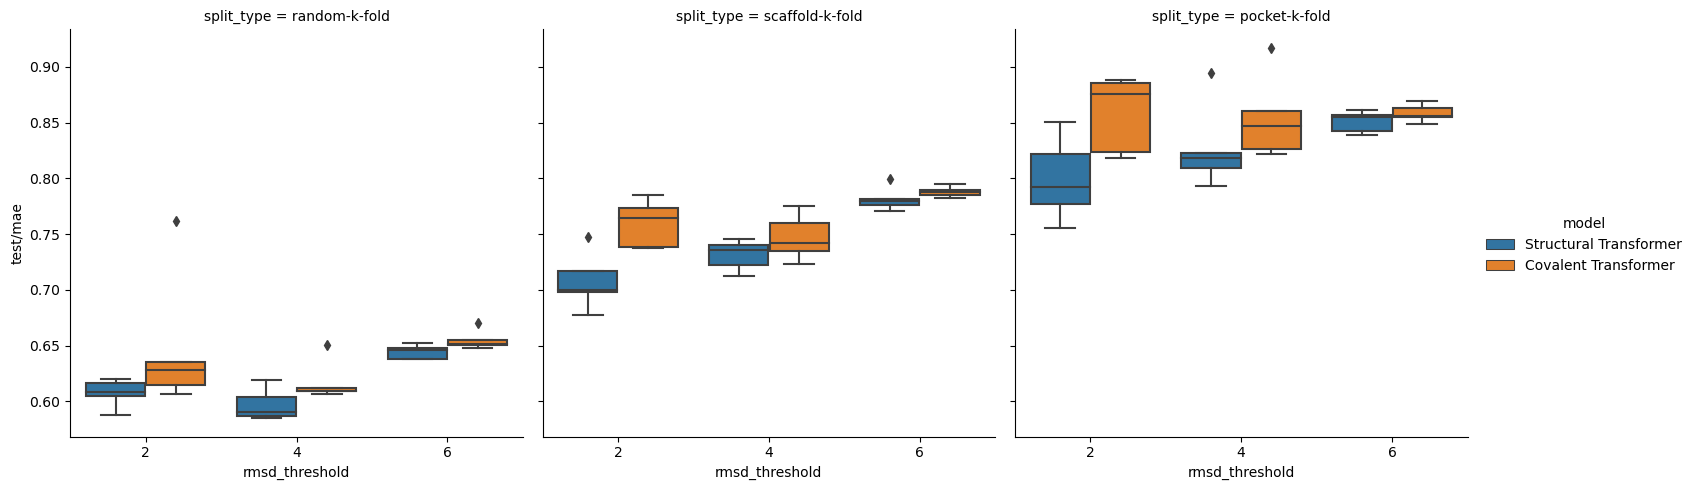

In [120]:
grid = sns.catplot(
    df, x="rmsd_threshold", y="test/mae", hue="model", kind="box",
    hue_order=["Structural Transformer", "Covalent Transformer"],
    col="split_type",sharey=True,
    col_order=["random-k-fold", "scaffold-k-fold", "pocket-k-fold"]
)

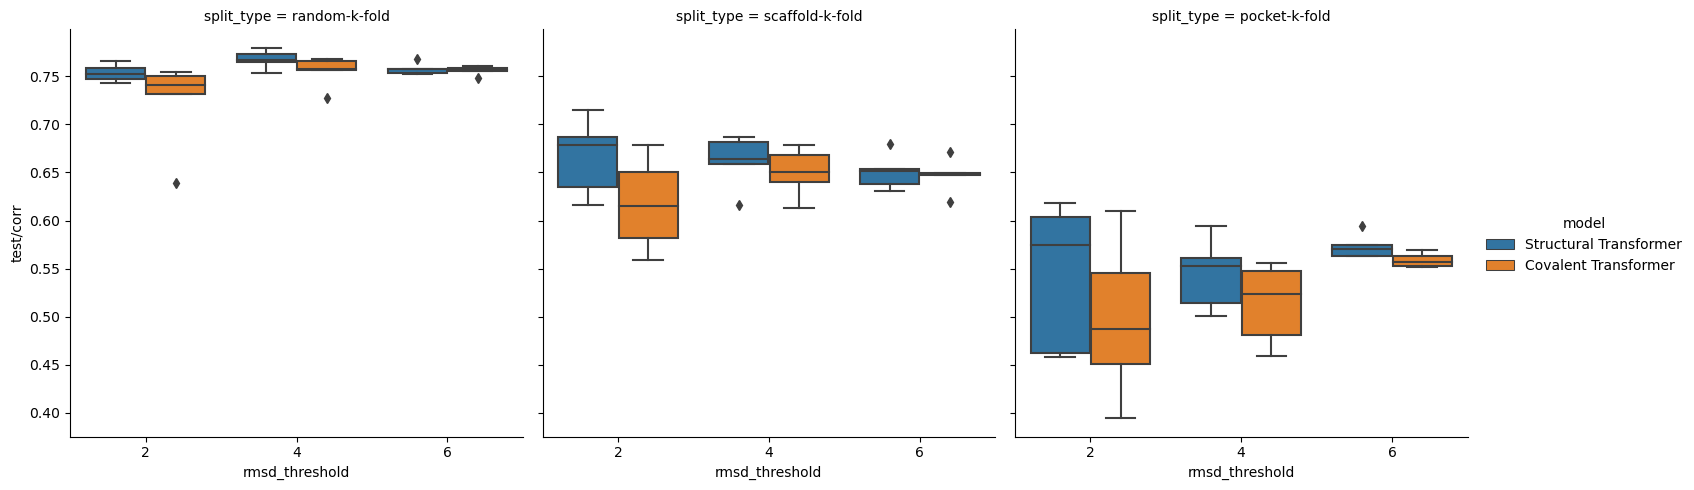

In [121]:
grid = sns.catplot(
    df, x="rmsd_threshold", y="test/corr", hue="model", kind="box",
    hue_order=["Structural Transformer", "Covalent Transformer"],
    col="split_type",sharey=True,
    col_order=["random-k-fold", "scaffold-k-fold", "pocket-k-fold"]
)

In [135]:
def point_estimate_repr(data):
    mean = data.mean()
    std = data.std()
    return f"{mean:.3f}±{std:.3f}"

In [226]:
df_struc = (
    df[["model", "split_type", "rmsd_threshold", "test/mae", "test/corr"]]
    .groupby(["rmsd_threshold", "split_type", "model"])
    .agg(["mean", "std"])
)
df_covalent = (
    df[["model", "split_type", "rmsd_threshold", "test/mae", "test/corr"]].query("model == 'Covalent Transformer'")
    .groupby(["split_type", "rmsd_threshold", "model"])
    .agg(point_estimate_repr)
) 

In [227]:
from collections import defaultdict


dic = defaultdict(lambda: defaultdict(dict))
for index, values in df_struc.iterrows():
    rmsd, split, model = index
    dic[rmsd][split][model] = values["test/mae"]

In [228]:
dic

defaultdict(<function __main__.<lambda>()>,
            {2: defaultdict(dict,
                         {'pocket-k-fold': {'Covalent Transformer': mean    0.858327
                           std     0.034301
                           Name: (2, pocket-k-fold, Covalent Transformer), dtype: float64,
                           'Structural Transformer': mean    0.799538
                           std     0.037316
                           Name: (2, pocket-k-fold, Structural Transformer), dtype: float64},
                          'random-k-fold': {'Covalent Transformer': mean    0.649105
                           std     0.063790
                           Name: (2, random-k-fold, Covalent Transformer), dtype: float64,
                           'Structural Transformer': mean    0.607028
                           std     0.012579
                           Name: (2, random-k-fold, Structural Transformer), dtype: float64},
                          'scaffold-k-fold': {'Covalent Transforme

In [235]:
def repr_point_estimate(row):
    return f"${row['mean']:.3f}" + "\\pm" +  "{\\tiny" + f"{row['std']:.2f}" + "}$"

In [236]:
for rmsd, data1 in dic.items():
    line = f"{rmsd} & "
    for split in ("random-k-fold", "scaffold-k-fold", "pocket-k-fold"):
        data2 = data1[split]
        struc = data2["Structural Transformer"] 
        cov = data2["Covalent Transformer"]
        line += f"{repr_point_estimate(struc)} & {repr_point_estimate(cov)}"
        line += "& &" if split != "pocket-k-fold" else ""
    line += " \\" + "\\"
    print(line)

2 & $0.607\pm{\tiny0.01}$ & $0.649\pm{\tiny0.06}$& &$0.708\pm{\tiny0.03}$ & $0.760\pm{\tiny0.02}$& &$0.800\pm{\tiny0.04}$ & $0.858\pm{\tiny0.03}$ \\
4 & $0.597\pm{\tiny0.01}$ & $0.617\pm{\tiny0.02}$& &$0.731\pm{\tiny0.01}$ & $0.747\pm{\tiny0.02}$& &$0.828\pm{\tiny0.04}$ & $0.854\pm{\tiny0.04}$ \\
6 & $0.644\pm{\tiny0.01}$ & $0.655\pm{\tiny0.01}$& &$0.781\pm{\tiny0.01}$ & $0.788\pm{\tiny0.00}$& &$0.851\pm{\tiny0.01}$ & $0.859\pm{\tiny0.01}$ \\


In [199]:
class PartiallFormat:
    
    def __init__(self, s: str):
        self.s = s
    
    def format(self, **kwargs):
        for key, value in kwargs.items():
            self.s = self.s.replace("{"+key+"}", str(value))
        return self
            
    def __repr__(self):
        return self.s

In [200]:
PartiallFormat("{a}, {b}").format(a=3)

3, {b}

In [190]:
for struc, cov in zip(df_struc.iterrows(), df_covalent.iterrows()):
    split = struc[0][0]
    line = PartiallFormat("{split} & ")
    for row in (struc, cov):
        split, rmsd, model = row[0]
        mae = row[1]["test/mae"]
        corr = row[1]["test/corr"]

0.543±0.078
0.498±0.084
0.544±0.038
0.513±0.042
0.573±0.013
0.559±0.007
0.754±0.009
0.723±0.048
0.768±0.010
0.755±0.016
0.758±0.006
0.756±0.005
0.667±0.040
0.617±0.049
0.661±0.028
0.650±0.025
0.651±0.019
0.647±0.018


In [145]:
df.groupby(["split_type", "rmsd_threshold", "model"]).agg(point_estimate_repr).drop(columns=["split_fold", "test/corr"]).query("model == 'Structural Transformer'")

/var/folders/8r/pydj0px5315ckmngntlp2m3c0000gn/T/ipykernel_50180/1057370978.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  df.groupby(["split_type", "rmsd_threshold", "model"]).agg(point_estimate_repr).drop(columns=["split_fold", "test/corr"]).query("model == 'Structural Transformer'")


test/mae
split_type      rmsd_threshold model                              
pocket-k-fold   2              Structural Transformer  0.800±0.037
                4              Structural Transformer  0.828±0.039
                6              Structural Transformer  0.851±0.010
random-k-fold   2              Structural Transformer  0.607±0.013
                4              Structural Transformer  0.597±0.015
                6              Structural Transformer  0.644±0.006
scaffold-k-fold 2              Structural Transformer  0.708±0.026
                4              Structural Transformer  0.731±0.013
                6              Structural Transformer  0.781±0.011

In [ ]:
"""
\begin{table}[]
    \centering
    \begin{tabular}{lccccc}
    \toprule
    {} & \multicolumn{2}{c}{$r^2$ $\uparrow$} & &\multicolumn{2}{c}{{MAE $\downarrow$}} \\
    \cmidrule{2-3}\cmidrule{5-6}
    Split &                      Complex-EGNN    &  Ligand-GNN &                 \hspace{1em} & Complex-EGNN & Ligand-GNN\\
    \midrule
    random   &  { ${0.71 \pm 0.006}$} &  { $0.68 \pm 0.008$} & & {$0.66 \pm 0.013$} & {$0.69 \pm 0.010$} \\
    scaffold &  { ${0.57 \pm 0.048}$} &  { $0.31 \pm 0.041$} & & {$0.78 \pm 0.021$} & {$1.10 \pm 0.097$} \\
    pocket   &  { ${0.33 \pm 0.078}$} &  { $0.13 \pm 0.081$} & & {$0.89 \pm 0.063$} & {$1.26 \pm 0.181$} \\
    \bottomrule
    \end{tabular}
    \caption{Correlation and \ac{MAE} of predicted and ground truth activity values on test data.}
    \label{tab:result_summary}
\end{table}
"""

ValueError: ('Lengths must match to compare', (90,), (2,))

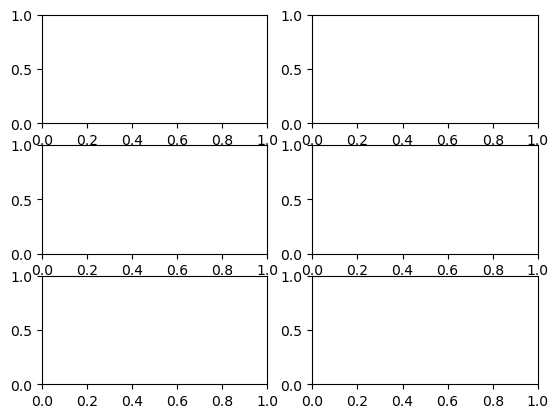

In [11]:
fig, axes = plt.subplots(3, 2)
for ax, split_type in zip(U["split_type"], axes):
    grid = sns.catplot(
        df[df.split_type == split_type], x="rmsd_threshold", y="test/mae", hue="model", kind="box",
        hue_order=["Structural Transformer", "Covalent Transformer"],
        ax=ax[0]
    )
    # grid.map_dataframe(sns.stripplot, x="rmsd_threshold", y="test/mae", hue="model", dodge=True)
    plt.title(split_type)

In [ ]:
missing = [key for key, value in matrix.items() if len(value) == 0]
missing

[('random-k-fold', 4, 6, 'Structural Transformer')]

In [ ]:
for (split, index, rmsd, model) in missing:
    print(", ".join(map(str, (split, index, rmsd, model.lower().replace(" transformer", "") + ".yaml"))))

random-k-fold, 4, 6, structural.yaml


In [7]:
from kinodata.data.grouped_split import KinodataKFoldSplit, Split
from kinodata.data.dataset import KinodataDocked, Filtered
from kinodata.transform import FilterDockingRMSD

In [10]:
rmsd_dataset = {
    threshold: Filtered(KinodataDocked(), FilterDockingRMSD(threshold))()
    for threshold in (2.0, 4.0, 6.0)
}

In [54]:
separated_datasets = [
    pd.DataFrame({
        "data": [data for data in dataset],
        "index": list(range(len(dataset))),
    })
    for threshold, dataset in rmsd_dataset.items()
]

In [75]:
separated_datasets[0]["rmsd"] = 2.0
separated_datasets[1]["rmsd"] = 4.0
separated_datasets[2]["rmsd"] = 6.0

In [76]:
separated_ddf = pd.concat(separated_datasets, axis=0)

In [77]:
separated_ddf["affinity"] = separated_ddf["data"].apply(lambda d: d.y.item())

In [104]:
source_data_frame = KinodataDocked().df

Reading data frame..
Checking for missing pocket mol2 files...


100%|██████████| 2885/2885 [00:00<00:00, 32991.71it/s]


Adding pocket sequences from cached file /Users/joschka/projects/kinodata-docked-rescore/data/raw/pocket_sequences.csv.


In [105]:
source_data_frame = source_data_frame.reset_index()
source_data_frame["ident"] = source_data_frame["ident"].astype(int)
source_data_frame = source_data_frame.set_index("ident")
for col in ("activities.standard_value", "docking.predicted_rmsd"):
    source_data_frame[col] = source_data_frame[col].astype(float)
source_data_frame = source_data_frame[source_data_frame["docking.predicted_rmsd"] <= 8.0]

In [106]:
source_data_frame["docking.predicted_rmsd"].describe()

count    119572.000000
mean          4.099008
std           1.974531
min          -1.341663
25%           2.195908
50%           4.601303
75%           5.789720
max           7.999485
Name: docking.predicted_rmsd, dtype: float64

In [37]:
splits = {
    threshold: {
        split_type: KinodataKFoldSplit(split_type, 5).split(dataset)
        for split_type in ("random-k-fold", "scaffold-k-fold", "pocket-k-fold")
    }
    for threshold, dataset in rmsd_dataset.items()
}

In [38]:
import pandas as pd
import seaborn as sns

In [85]:
def affinity(rmsd=None, split=None):
    data = separated_ddf
    if rmsd is not None:
        data = data[data.rmsd == rmsd]
    if split is not None:
        data = data.set_index("index").loc[split.test_split]
    return data["affinity"]

## Dataset size and target distributions for RMSD thresh. in (2,4,6)

In [91]:
rmsd_data_frame = pd.DataFrame(
    {
        "rmsd": list(rmsd_dataset.keys()),
        "size": [len(dataset) for dataset in rmsd_dataset.values()],
        "mean_affinity": [affinity(threshold).mean() for threshold in rmsd_dataset],
        "std_affinity": [affinity(threshold).std() for threshold in rmsd_dataset]
    }
)

In [92]:
rmsd_data_frame

,rmsd,size,mean_affinity,std_affinity
0,2.0,27418,7.414377,1.201378
1,4.0,49311,7.260845,1.232588
2,6.0,94399,7.088212,1.294951


<AxesSubplot: xlabel='rmsd', ylabel='size'>

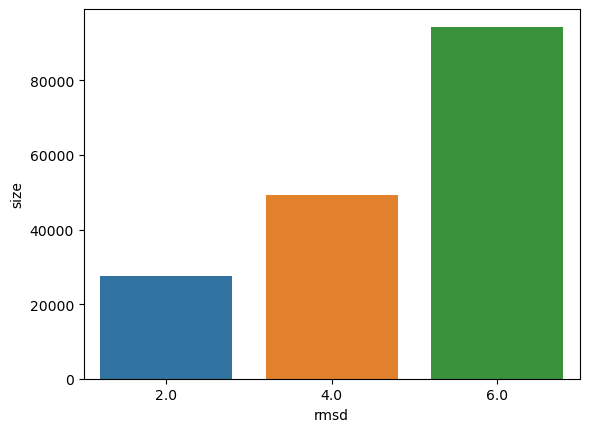

In [21]:
sns.barplot(rmsd_data_frame, x="rmsd", y="size")

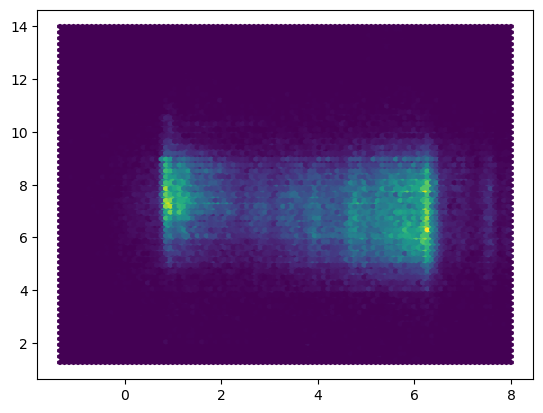

In [109]:
import matplotlib.pyplot as plt

plt.hexbin(
    source_data_frame["docking.predicted_rmsd"].astype(float),
    source_data_frame["activities.standard_value"].astype(float),
)

In [110]:
source_data_frame[["docking.predicted_rmsd", "activities.standard_value"]].corr()

,docking.predicted_rmsd,activities.standard_value
docking.predicted_rmsd,1.000000,-0.148169
activities.standard_value,-0.148169,1.000000
